# || Overview
- Elo has built partnerships with merchants in order to offer promotions or discounts to cardholders
- Kagglers will develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty.
- This way Elo reduces unwanted campaigns, to create the right experience for customers.
- Submissions are scored on **RMSE**
- $\hat{y}$ is the predicted loyalty score for each card_id
- **February 26, 2019** - Final submission deadline.
- All data is simulated and fictitious, and is not real customer data

- the **train.csv** and **test.csv** files contain the card_ids that we'll be using for training and prediction.

# || References
- https://www.kaggle.com/c/elo-merchant-category-recommendation
- https://www.kaggle.com/c/elo-merchant-category-recommendation/kernels
- https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion

# || Loading Packages

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, time, gc

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# || Configuration

In [5]:
np.random.seed(100)
t_start = time.time()

# || Load and Clean the Data

In [6]:
! ls ../input/

Data_Dictionary.xlsx	     new_merchant_transactions.csv  train.csv
historical_transactions.csv  sample_submission.csv
merchants.csv		     test.csv


In [7]:
%%time
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

CPU times: user 1min 10s, sys: 17.1 s, total: 1min 27s
Wall time: 1min 27s


In [8]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

# || Feature Engineering

In [9]:
def get_new_columns(name, aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [10]:
for df in [df_hist_trans, df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >= 5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    
    df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0})
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [11]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

42

In [12]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

28

In [13]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_weekend_sum,hist_weekend_mean,hist_category_1_sum,hist_category_1_mean,hist_card_id_size,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,new_hist_month_nunique,new_hist_hour_nunique,new_hist_weekofyear_nunique,new_hist_dayofweek_nunique,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_purchase_amount_sum,new_hist_purchase_amount_max,new_hist_purchase_amount_min,new_hist_purchase_amount_mean,new_hist_purchase_amount_var,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_purchase_date_max,new_hist_purchase_date_min,new_hist_month_lag_max,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_month_diff_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,9,23,35,7,2,21,94,41,-165.968739,2.258395,-0.739395,-0.638341,0.045003,4,1,0,0.015385,0.015206,2018-02-25 09:31:15,2017-06-27 14:18:08,0,-8,-3.911538,5.748901,12.134615,247,0.950000,90,0.346154,0,0.000000,260,0.072502,0.346719,242,0.930769,366,2.0,8.0,7.0,7.0,1.0,10.0,23.0,14.0,-13.244202,-0.296112,-0.724368,-0.575835,0.018445,0.0,0.0,0.0,0.000000,0.000000,2018-04-29 11:23:05,2018-03-05 14:04:36,2.0,1.0,1.478261,0.260870,12.000000,6.0,0.260870,0.0,0.000000,23.0,-0.550160,-0.592993,54.0,2.347826,303.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,12,24,50,7,2,24,142,57,-210.006336,4.630299,-0.742400,-0.600018,0.148200,543,10,-1,1.551429,2.282448,2018-01-31 22:31:09,2017-01-06 16:29:42,0,-12,-5.031429,14.477519,13.145714,339,0.968571,132,0.377143,31,0.088571,350,0.074568,-0.295163,390,1.114286,391,2.0,5.0,4.0,4.0,1.0,4.0,6.0,5.0,-4.355735,-0.701858,-0.739410,-0.725956,0.000205,6.0,1.0,1.0,1.000000,0.000000,2018-03-30 06:48:26,2018-02-01 17:07:54,2.0,1.0,1.500000,0.300000,13.166667,0.0,0.000000,0.0,0.000000,6.0,-0.550160,-0.606486,56.0,9.333333,333.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,10,14,22,7,2,7,13,8,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,0,0,0,0.000000,0.000000,2018-02-27 19:08:25,2017-01-11 08:21:22,0,-13,-8.604651,14.768549,12.093023,41,0.953488,11,0.255814,0,0.000000,43,-0.087803,0.358458,412,9.581395,364,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.700326,-0.700326,-0.700326,-0.700326,NaN,0.0,0.0,0.0,0.000000,NaN,2018-04-28 17:43:11,2018-04-28 17:43:11,2.0,2.0,2.000000,NaN,12.000000,1.0,1.000000,0.0,0.000000,1.0,-0.549015,-0.592993,0.0,0.000000,304.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,6,16,20,7,2,13,50,25,-49.491364,1.445596,-0.740897,-0.642745,0.068447,84,3,-1,1.090909,0.346890,2018-02-28 11:44:40,2017-09-26 16:22:21,0,-5,-2.831169,3.247437,12.090909,77,1.000000,11,0.142857,12,0.155844,77,-0.086166,-0.338321,154,2.000000,363,2.0,5.0,5.0,4.0,1.0,5.0,7.0,6.0,-4.654372,-0.566740,-0.734135,-0.664910,0.004340,5.0,1.0,-1.0,0.714286,0.571429,2018-04-18 11:00:11,2018-03-07 11:55:06,2.0,1.0,1.714286,0.238095,12.000000,3.0,0.428571,1.0,0.142857,7.0,-0.556518,-0.604559,41.0,5.8

In [14]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [15]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [16]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

# || Create model & Train

In [17]:
param = {
    'num_leaves': 31,
    'min_data_in_leaf': 30, 
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.01,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 4590
}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66559	valid_1's rmse: 3.72206
[200]	training's rmse: 3.58895	valid_1's rmse: 3.6892
[300]	training's rmse: 3.54307	valid_1's rmse: 3.67552
[400]	training's rmse: 3.50697	valid_1's rmse: 3.66758
[500]	training's rmse: 3.47818	valid_1's rmse: 3.66303
[600]	training's rmse: 3.45363	valid_1's rmse: 3.65939
[700]	training's rmse: 3.43081	valid_1's rmse: 3.6575
[800]	training's rmse: 3.41003	valid_1's rmse: 3.65645
[900]	training's rmse: 3.39155	valid_1's rmse: 3.65549
[1000]	training's rmse: 3.37444	valid_1's rmse: 3.65479
[1100]	training's rmse: 3.35809	valid_1's rmse: 3.6547
Early stopping, best iteration is:
[1078]	training's rmse: 3.36171	valid_1's rmse: 3.65457
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66755	valid_1's rmse: 3.71489
[200]	training's rmse: 3.59036	valid_1's rmse: 3.68476
[300]	training's rmse: 3.54173	valid_1's rmse: 3.6743
[

3.65447494724389

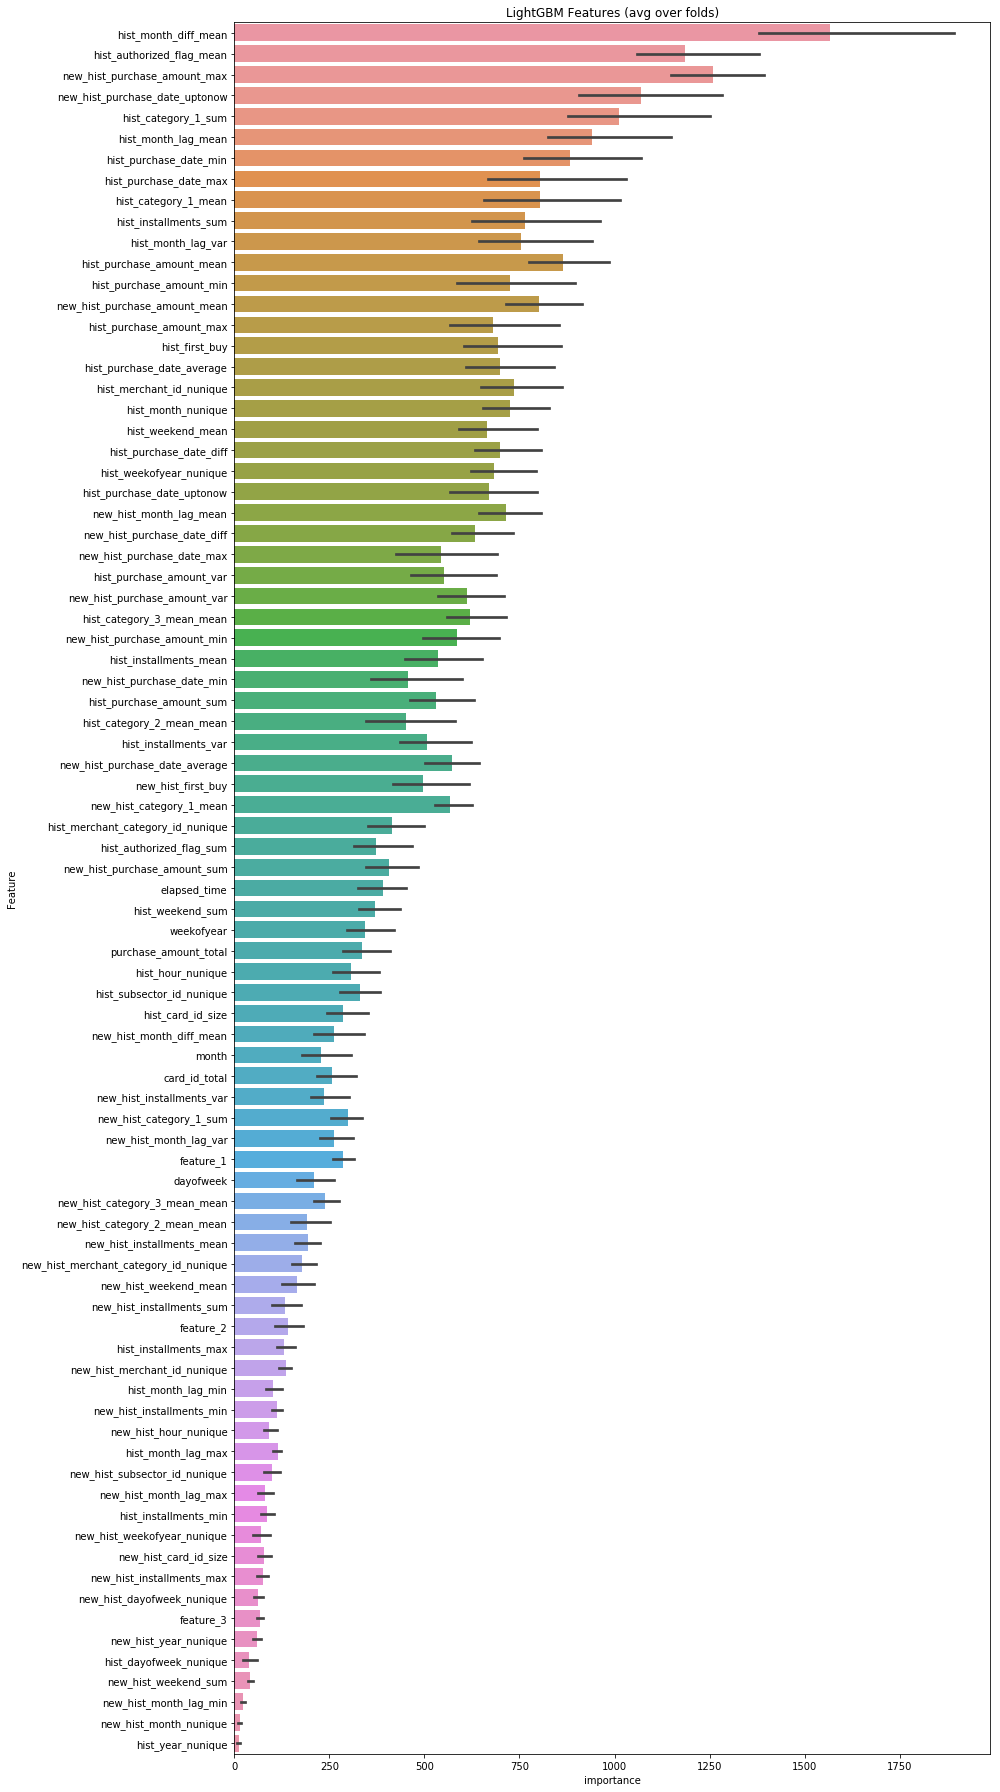

In [18]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# || Predict submission

In [19]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

In [20]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 0.20614964776568942 hours
